# Building an example supply chain with dynamic alteration

The bio-base construction group has the following LCA diagram:

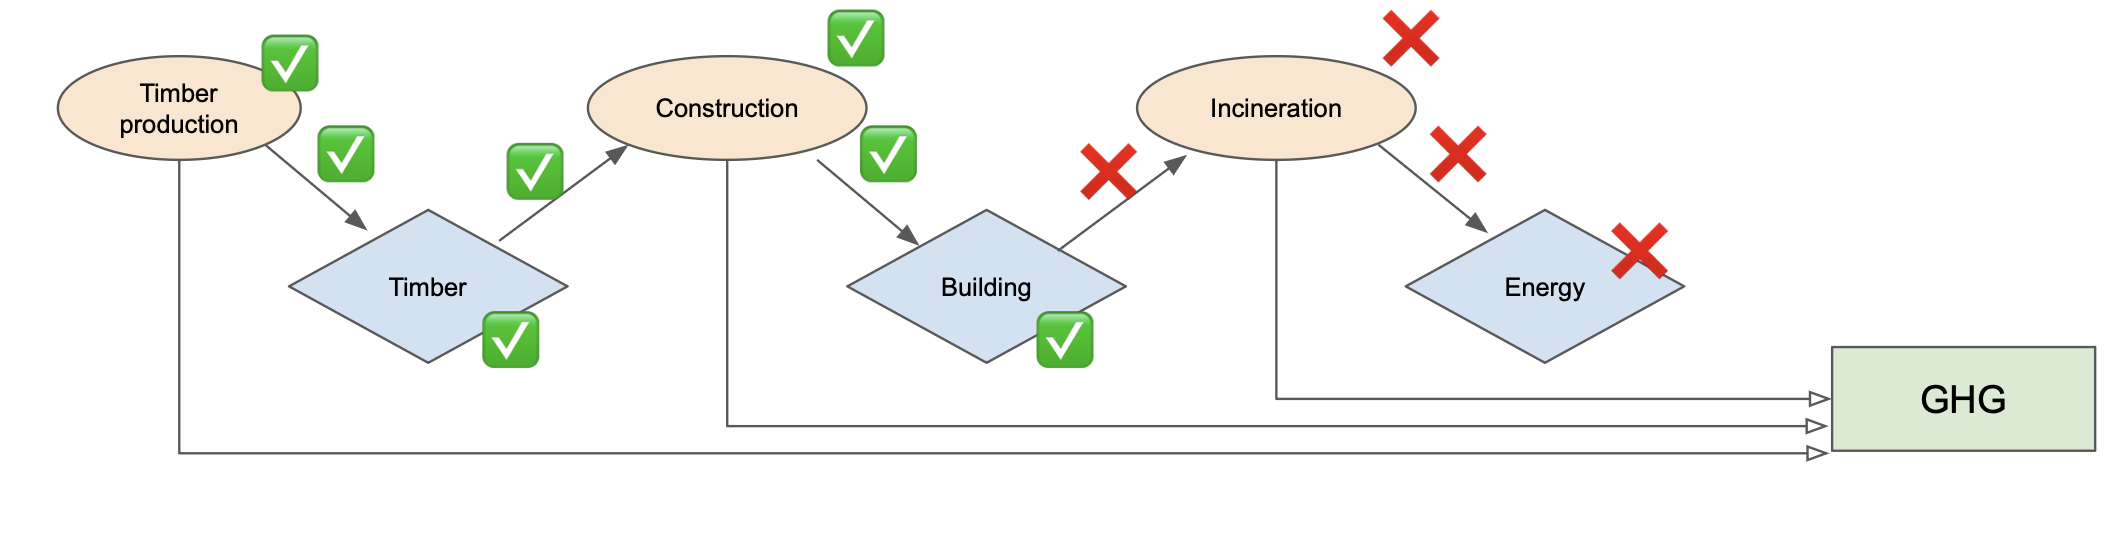

We can use this as an example, with a small change: we will create a node to act as our functional unit. In this case, the functional unit is the life cycle of total wood-based housing in Germany.

In [1]:
import bw2data as bd
import bw2calc as bc
import bw_processing as bwp
import numpy as np
from dataclasses import dataclass

In [2]:
bd.projects.set_current("ecoinvent-3.10-cutoff")

The actual supply chain coefficients will come from the MFA. We can create our supply chain with dummy values.

In [3]:
if "Construction" in bd.databases:
    del bd.databases["Construction"]

In [4]:
db = bd.Database("Construction")
db.register()

In [5]:
construction_timber = db.new_node(
    name="Construction timber",
    type=bd.labels.product_node_default,
    unit="cubic meter",
)
building = db.new_node(
    name="Total wood-framed building supply",
    type=bd.labels.product_node_default,
    unit="square meter",
)
building_service = db.new_node(
    name="Wood-framed building services for Germany",
    type=bd.labels.product_node_default,
    unit="person-year",
)
waste_treatment = bd.get_node(
    name='treatment of municipal solid waste, municipal incineration', 
    location="DE", 
    unit="kilogram"
)
electricity = bd.get_node(
    name='market for electricity, low voltage', 
    location="DE", 
    unit="kilowatt hour"
)

construction_timber.save()
building.save()
building_service.save()

/opt/tljh/user/envs/bw25/lib/python3.12/site-packages/bw2data/utils.py:375: UserWarning: Given search criteria very broad; try to specify at least a database
  warnings.warn("Given search criteria very broad; try to specify at least a database")


And the processes. We will go from left to right, starting with timber production. We can copy the production process from ecoinvent, but insert our own product:

`Timber production ->Construction timber`

In [6]:
timber_production = bd.get_node(
    name='structural timber production', 
    location='RER', 
    **{"reference product": "structural timber"}
).copy(
    database=db.name,
    type=bd.labels.process_node_default
)
# Replace default product with our custom one
for exc in timber_production.production():
    exc.delete()

timber_production.new_edge(
    input=construction_timber,
    amount=1, # Dummy value
    type=bd.labels.production_edge_default
).save()

The timber is used by building construction:

`Construction timber->Construction->Building`

In [7]:
building_construction = db.new_node(
    name="Building construction",
    location="DE",
    type=bd.labels.process_node_default
)
building_construction.save()

building_construction.new_edge(
    input=construction_timber,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()
building_construction.new_edge(
    input=building,
    amount=1,
    type=bd.labels.production_edge_default
).save()

The building life cycle has material and energy inputs, and produces End-of-Life waste:

`Building|Energy->Building lifecycle->Housing service|EoL Waste`

In [8]:
building_lifecycle = db.new_node(
    name="Building life cycle",
    location="DE",
    type=bd.labels.process_node_default
)
building_lifecycle.save()

building_lifecycle.new_edge(
    input=building,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()
building_lifecycle.new_edge(
    input=electricity,
    amount=1,
    type=bd.labels.consumption_edge_default
).save()
building_lifecycle.new_edge(
    input=building_service,
    amount=1,
    functional=True,
    type=bd.labels.production_edge_default
).save()
building_lifecycle.new_edge(
    input=waste_treatment,
    amount=1,
    functional=False,
    type=bd.labels.production_edge_default
).save()

This is our basic supply chain. Let's build some arrays for what the different edge coefficients could be. I am just making these up for now, they should come from the MFA/other statistics.

Because I don't have a time resolution from the MFA, I will pick ten time periods going into the future. We need to provide values for the following:

* Timber (m3) used in new housing construction (m2)
* Annual housing construction (m2) added to total housing stock
* Electricity consumption (kWh) used in total housing stock
* Solid waste (kg) produced by total housing stock

Let's make a suitable data structure for this information:

In [9]:
@dataclass
class DataArray:
    input_node: bd.Node
    output_node: bd.Node
    array: np.ndarray
    consumption: bool = True

And fill in some data:

In [18]:
timber_use = DataArray(
    input_node=construction_timber,
    output_node=building_construction,
    array=np.linspace(2, 1.5, 10)  # Just guesses - from 2 to 1.5 m3/m2 over 10 years
)
housing_addition = DataArray(
    input_node=building,
    output_node=building_lifecycle,
    array=np.array([5e6, 2.5e6, 1e6, 5e5, 1e5] + [0] * 5)  # Simulate no new construction - just an example
)
electricity_consumption = DataArray(
    input_node=electricity,
    output_node=building_lifecycle,
    array=np.linspace(1e8, 2e8, 10) # Electrification of services
)
housing_waste = DataArray(
    input_node=waste_treatment,
    output_node=building_lifecycle,
    array=np.array([1e6] * 10),  # Constant waste production,
    consumption=False,
)

Write a function to turn this into a dynamic datapackage that Brightway can consume:

In [27]:
def data_obj_for_arrays(arrays: list[DataArray]) -> bwp.Datapackage:
    for dc in arrays:
        assert isinstance(dc, DataArray), "Oops, wrong input type"

    data_array = np.vstack([dc.array for dc in arrays])
    indices_array = np.array(
        [(dc.input_node.id, dc.output_node.id) for dc in arrays], 
        dtype=bwp.INDICES_DTYPE
    )
    flip_array = np.array([not dc.consumption for dc in arrays])
    dp = bwp.create_datapackage(
        sequential=True
    )
    dp.add_persistent_array(
        matrix="technosphere_matrix",
        indices_array=indices_array,
        data_array=data_array,
        flip_array=flip_array,
    )
    return dp

In [28]:
dp = data_obj_for_arrays([
    timber_use,
    housing_addition,
    electricity_consumption,
    housing_waste
])

We can now use this datapackage the same as our other data objs.

In [29]:
ipcc = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')

In [30]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs({building_service: 1}, method=ipcc)

In [31]:
lca = bc.LCA(functional_unit, data_objs = data_objs + [dp], use_arrays=True)
lca.lci()
lca.lcia()

Let's check and make sure our dynamic values got inserted. Because we used `sequential=True`, we should for the first element of each array. Note that the consumption values will be negative.

In [32]:
print(
    "Should be 2:",
    lca.technosphere_matrix[
        lca.dicts.product[construction_timber.id],
        lca.dicts.activity[building_construction.id],
    ],
)

Should be 2: 2.0


In [33]:
print(
    "Should be 5e6:",
    lca.technosphere_matrix[
        lca.dicts.product[building.id],
        lca.dicts.activity[building_lifecycle.id],
    ],
)

Should be 5e6: 5000000.0


Because we supplied arrays, we can iterate over the `LCA` object to get the next time period. Let's look at the score for the first time period and the second:

In [34]:
lca.score

900777610.7199985

In [35]:
next(lca)
lca.score

413067338.4344732

Because we made up our numbers, the large decrease in housing addition is driving this result.